# Introduction

Approach and Solution to break in Top 20 of Big Mart Sales prediction

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read files:
train = pd.read_csv("bigdatamart_Train.csv")
test = pd.read_csv("bigdatamart_Test.csv")

In [3]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Its generally a good idea to combine both train and test data sets into one, perform feature engineering and then divide them later again. This saves the trouble of performing the same steps twice on test and train. Lets combine them into a dataframe ‘data’ with a ‘source’ column specifying where each observation belongs.

In [5]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
train.shape, test.shape, data.shape

((8523, 13), (5681, 12), (14204, 13))

In [6]:
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

Note that the Item_Outlet_Sales is the target variable and missing values are ones in the test set. So we need not worry about it. But we’ll impute the missing values in Item_Weight and Outlet_Size in the data cleaning section.

Lets look at some basic statistics for numerical variables.

In [7]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Some observations:

1. As we can see Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.
2. Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.
3. The lower ‘count’ of Item_Weight and Item_Outlet_Sales confirms the findings from the missing value check.

In [8]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

From above data we find that there are 1559(Item_Identifier) products and 10 outlets/stores(Outlet_Identifier) (which was also mentioned in problem statement). Another thing that should catch attention is that Item_Type has 16(Item_Type) unique values. Let’s explore further using the frequency of different categories in each nominal variable. I’ll drop the ID and source variables for obvious reasons.

In [9]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print ("\nFrequency of Categories for varible %s"%col)
    print (data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

Some Observation from above data
1. Item_Fat_Content: Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘regular’.
2. Item_Type: Not all categories have substantial numbers. It looks like combining them can give better results.
3. Outlet_Type: Supermarket Type2 and Type3 can be combined. But we should check if that’s a good idea before doing it.

# Data Visualisation

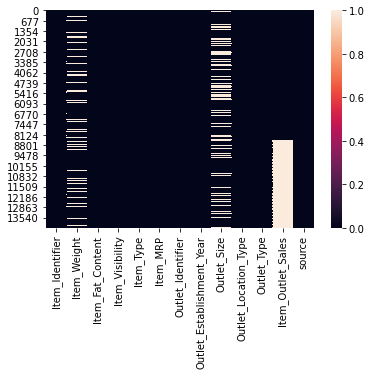

In [10]:
sns.heatmap(data.isnull())

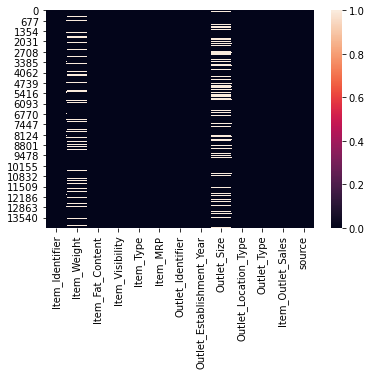

In [11]:
data['Item_Outlet_Sales']=data['Item_Outlet_Sales'].fillna(0)

sns.heatmap(data.isnull())

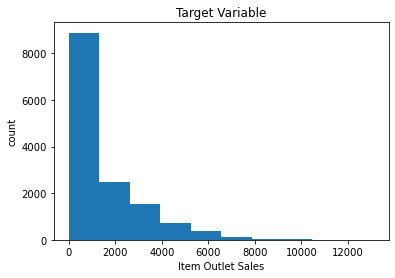

In [12]:
plt.hist(data['Item_Outlet_Sales'], bins = 10)
plt.title('Target Variable')
plt.xlabel('Item Outlet Sales')
plt.ylabel('count')
plt.show()

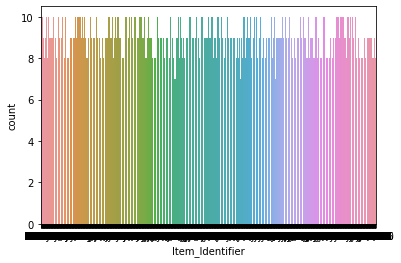

In [13]:
sns.countplot(data['Item_Identifier'])

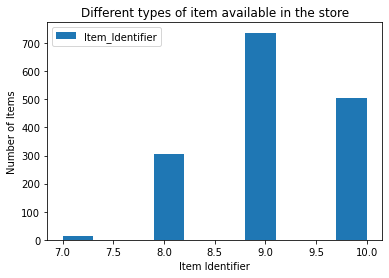

In [14]:
data['Item_Identifier'].value_counts(normalize = True)
data['Item_Identifier'].value_counts().plot.hist(bins=10)
plt.title('Different types of item available in the store')
plt.xlabel('Item Identifier')
plt.ylabel('Number of Items')
plt.legend()
plt.show()

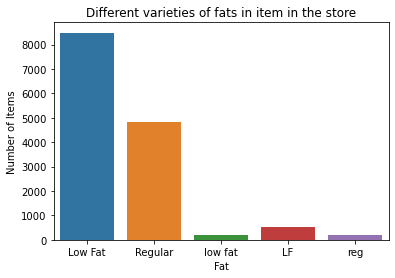

In [15]:
sns.countplot(data['Item_Fat_Content'])
plt.title('Different varieties of fats in item in the store')
plt.xlabel('Fat')
plt.ylabel('Number of Items')
plt.show()

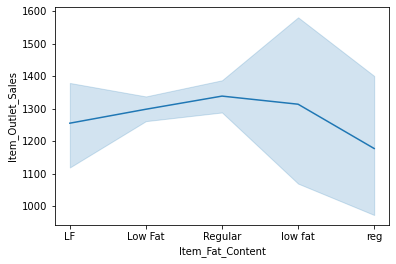

In [16]:
sns.lineplot(x='Item_Fat_Content',y='Item_Outlet_Sales',data=data)

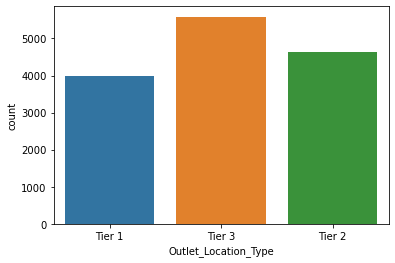

In [17]:
sns.countplot(data['Outlet_Location_Type'])

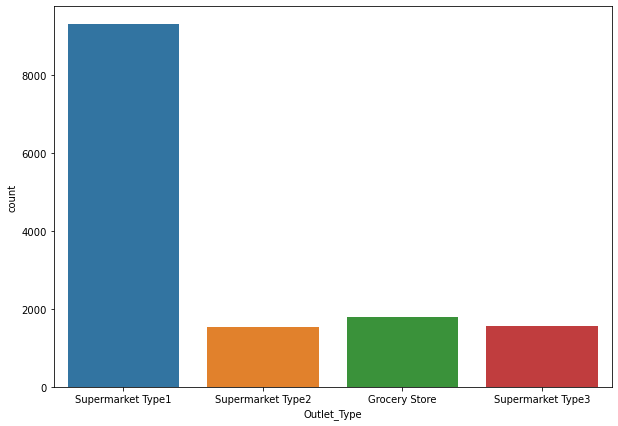

In [18]:
plt.figure(figsize=(10,7))

sns.countplot(data['Outlet_Type'])

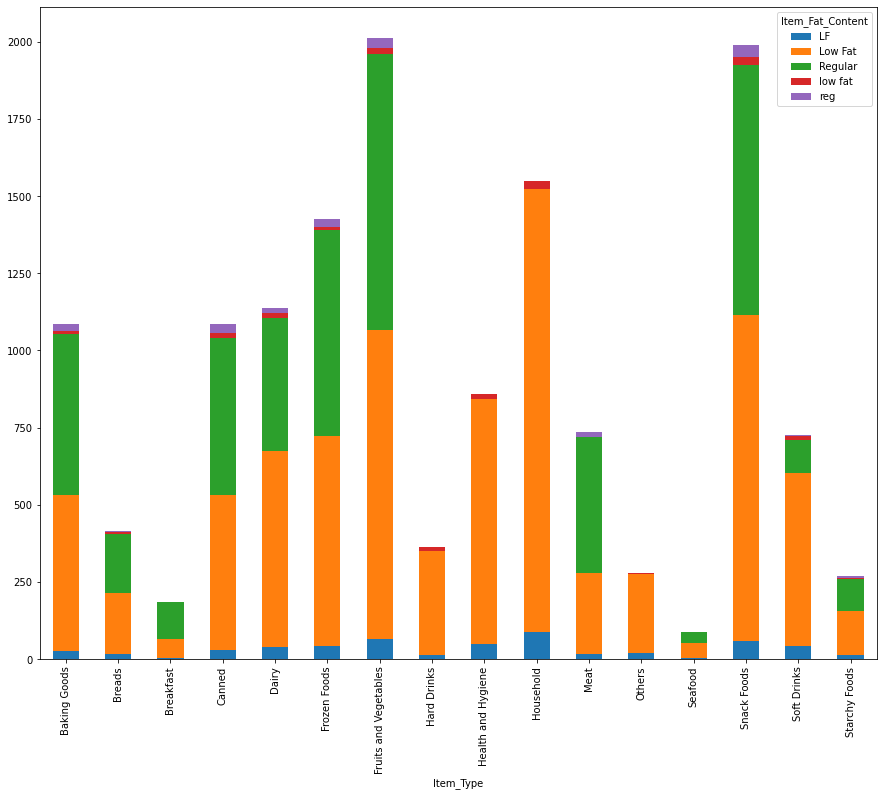

In [19]:
pd.crosstab(data['Item_Type'],data['Item_Fat_Content']).plot(kind="bar", stacked=True,figsize=(15,12))

# Data Cleaning

Here we will be reomoving missing values and treating outliers. Though outlier removal is very important in regression techniques, advanced tree based algorithms are impervious to outliers. So I’ll leave it to you to try it out. We’ll focus on the imputation step here, which is a very important step.

In [20]:
data.apply(lambda x: sum(x.isnull()))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source                          0
dtype: int64

In [21]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.at[x,'Item_Weight'])
#data.loc[miss_bool,‘Item_Weight’] = data.loc[miss_bool,‘Item_Identifier’].apply(lambda x: visibility_avg[x])
print ('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


From above its confirms that the column has no missing values now.

In [22]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print ('Mode for each Outlet_Type:')
print (outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print (sum(data['Outlet_Size'].isnull()))

Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Orignal #missing: 4016
0


This confirms that there are no missing values in the data.

    1.Consider combining Outlet_Type

Let's combine the Supermarket Type2 and Type3 variables to analyze the mean sales by type of store. If they have similar sales, then keeping them separate won’t help much.

In [23]:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,203.897100
Supermarket Type1,1389.858216
Supermarket Type2,1197.815543
Supermarket Type3,2215.475338


    2. Modify Item_Visibility
We noticed that the minimum value here is 0, which makes no practical sense. Lets consider it like missing information and impute it with mean visibility of that product.

In [24]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.at[x,'Item_Visibility'])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


So we can see that there are no values which are zero.

We should look at the visibility of the product in that particular store as compared to the mean visibility of that product across all stores. This will give some idea about how much importance was given to that product in a store as compared to other stores. We can use the ‘visibility_avg’ variable made above to achieve this.

In [25]:
#Determine another variable with means ratio

#data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
data['Item_Visibility_meanratio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']],axis=1)
print (data['Item_Visibility_meanratio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_meanratio, dtype: float64


Thus the new variable has been successfully created

    3. Create a broad category of Type of Item
Earlier we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. But there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [26]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

    4. Determine the years of operation of a store
We wanted to make a new column depicting the years of operation of a store. This can be done as:

In [27]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

This shows stores which are 4-28 years old

     5. Modify categories of Item_Fat_Content
We found typos and difference in representation in categories of Item_Fat_Content variable. This can be corrected as below

In [28]:
#Change categories of low fat:
print ('Original Categories:')
print (data['Item_Fat_Content'].value_counts())

print ('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print (data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


Now we saw there were some non-consumables as well and a fat-content should not be specified for them. So we can also create a separate category for such kind of observations.

In [29]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

    6. Numerical and One-Hot Coding of Categorical variables
Since scikit-learn accepts only numerical variables, I converted all categories of nominal variables into numeric types. Also, I wanted Outlet_Identifier as a variable as well. So I created a new variable ‘Outlet’ same as Outlet_Identifier and coded that. Outlet_Identifier should remain as it is, because it will be required in the submission file.

In [30]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])
    #One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_meanratio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

In [31]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


# Exporting Data for Model Building

In [32]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

# Model Building

In [33]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
base1.to_csv("alg0.csv",index=False)

In [34]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

# Linear Regression Model


Model Report
RMSE : 1128
CV Score : Mean - 1129 | Std - 43.78 | Min - 1075 | Max - 1214


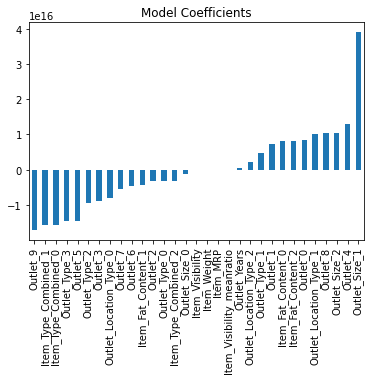

In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

# Ridge Regression Model:


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


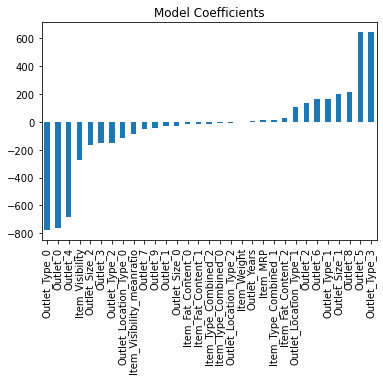

In [37]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

# Decision Tree Model


Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186


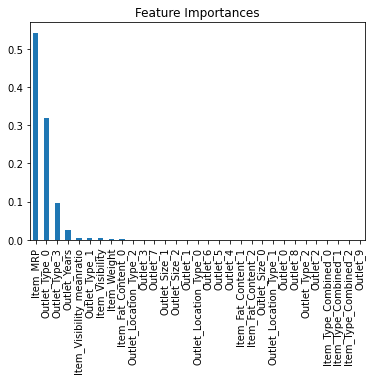

In [38]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')


Model Report
RMSE : 1071
CV Score : Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172


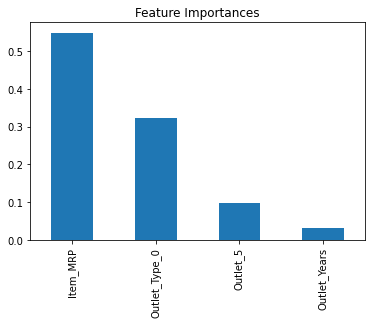

In [39]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

# Random Forest Model


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 44.06 | Min - 1020 | Max - 1163


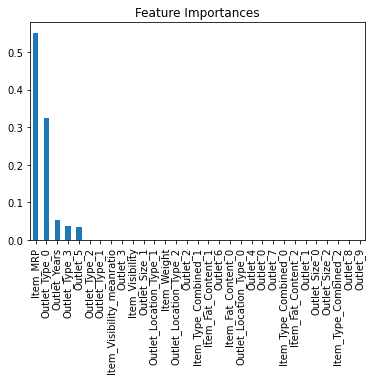

In [40]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')


Model Report
RMSE : 1068
CV Score : Mean - 1083 | Std - 43.59 | Min - 1020 | Max - 1160


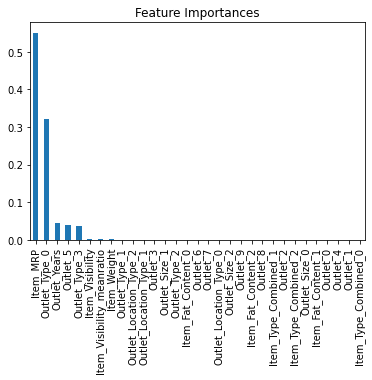

In [41]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')

# XGBoost Model

In [44]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train[predictors], train[target], early_stopping_rounds=5, 
             eval_set=[(test[predictors], test[target])], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [55]:
#Predict training set:
train_df_predictions = my_model.predict(train[predictors])
# make predictions
predictions = my_model.predict(test[predictors])
from sklearn.metrics import mean_absolute_error
print ("Mean Absolute Error : " + str(mean_absolute_error(predictions, test[target])))
print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error((train[target]).values, train_df_predictions)))
IDcol.append(target)
submission = pd.DataFrame ({ x: test[x] for x in IDcol})
submission.to_csv("print.csv", index=False)

Mean Absolute Error : 113.24844915300169
RMSE : 989
